# Language Classification 

The dataset is a language dataset belonging to seven categories namely "Danish","English","French","German","Italian","Portugues" &"Spanish". This notebook attempts to do document classificaiton of this dataset using scikit learn.

###Loading the data

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.linear_model import SGDClassifier
from sklearn import cross_validation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import load_files
from sklearn.svm import LinearSVC
import codecs

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

CATEGORIES=["Danish","English","French","German","Italian","Portugues","Spanish"]
 
data=load_files('data/classification_dataset',categories=CATEGORIES)
documents = [codecs.open(f, 'r', "ISO-8859-1").read() for f in data.filenames]

print "Total Documents in all categories", len(documents)

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Total Documents in all categories 75


### Vectorizing Text Data

Scikit Learn works with features only having numeric values, we will use vectorizers to convert text to vectors before starting classification

###Visualization using t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.
Lets try to visualize the dataset after dimensionality reduction and fitting to t-sne for plotting in 2-D

In [2]:
vectors = TfidfVectorizer().fit_transform(documents)
vectors.shape

(75, 244147)

###Visualizing TF-IDF disribution with respect to categories.

Before using t-SNE it is better to do a dimensionality reduction using SVD to few dimensions for performance

In [3]:
X_reduced = TruncatedSVD(n_components=20, random_state=0).fit_transform(vectors)

In [4]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 74 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 75 / 75
[t-SNE] Mean sigma: 0.701361
[t-SNE] Iteration 25: error = 1.5036575, gradient norm = 0.0027769
[t-SNE] Iteration 50: error = 1.3950948, gradient norm = 0.0019322
[t-SNE] Iteration 75: error = 1.2702787, gradient norm = 0.0010147
[t-SNE] Iteration 100: error = 1.2431574, gradient norm = 0.0009682
[t-SNE] Iteration 100: gradient norm 0.000968. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.243157
[t-SNE] Iteration 125: error = 1.1960841, gradient norm = 0.0006883
[t-SNE] Iteration 125: gradient norm 0.000688. Finished.
[t-SNE] Error after 125 iterations: 1.243157


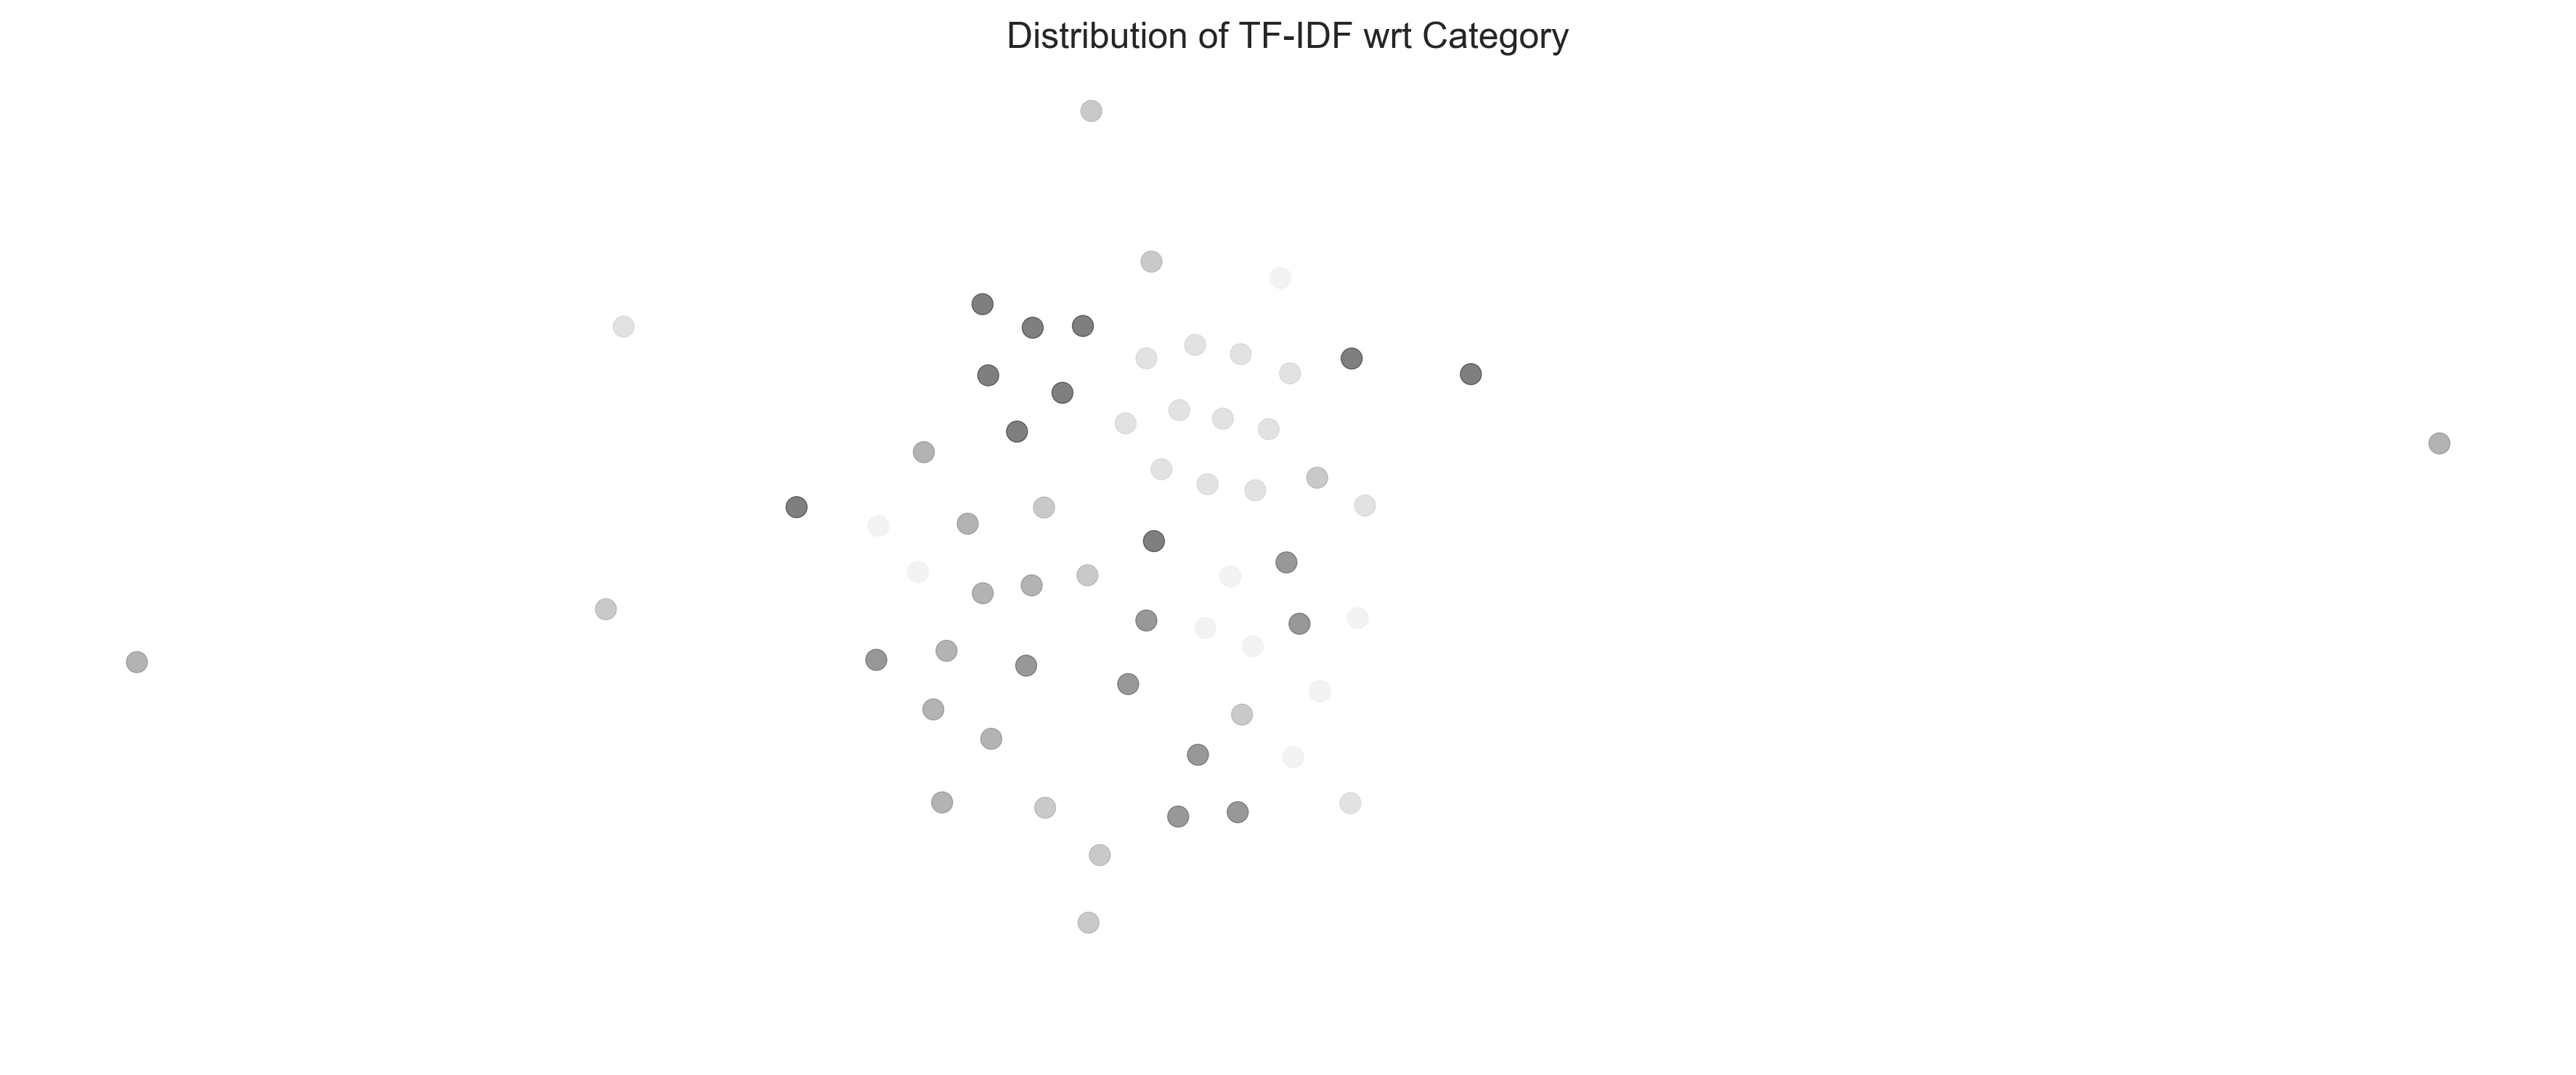

In [5]:
fig = plt.figure(figsize=(15,6), dpi=300) 
alpha = alpha_scatterplot = 0.8
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
        c=data.target, alpha=0.5)
plt.title("Distribution of TF-IDF wrt Category")


### Writing a classifier

Divide into test and train set

In [6]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(documents, \
                                                                     data.target,\
                                                                     test_size=0.3,\
                                                                     random_state=0)
print "Training Size ", len(X_train)
print "Test Size ", len(X_test)

Training Size  52
Test Size  23


In [7]:
pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier()),
    ])

# Already tried with Grid Search, these are the best parameters;
parameters = {
    'vect__max_df': (0.75,),
    'vect__ngram_range': ((1, 2),),  # unigrams or bigrams
    'tfidf__use_idf': (False,),
    'tfidf__norm': ('l2',),
    'clf__alpha': (0.00001,),
    'clf__penalty': ('l2', ),
    'clf__n_iter': (50,),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=5, verbose=1)
model = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=5)]: Done   3 out of   3 | elapsed:   54.2s finished


### Accuracy on train and test

In [8]:
score = model.score(X_train, y_train)
print "Mean accuracy on the train data is: {0}".format(score)

Mean accuracy on the train data is: 1.0


In [9]:
score = model.score(X_test, y_test)
print "Mean accuracy on the test data is: {0}".format(score)

Mean accuracy on the test data is: 1.0


Confusion matrix, without normalization
[[5 0 0 0 0 0 0]
 [0 7 0 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 0 4 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 3]]


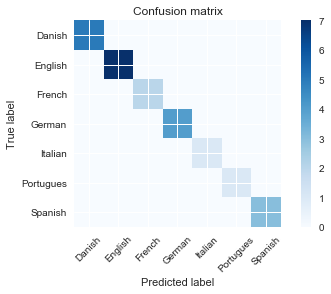

In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CATEGORIES))
    plt.xticks(tick_marks, CATEGORIES, rotation=45)
    plt.yticks(tick_marks, CATEGORIES)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 

y_pred = model.predict(X_test)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)